In [49]:
import cv2
import numpy as np
import os
from IPython.display import clear_output
from io import BytesIO
import PIL.Image
from pynq.overlays.base import BaseOverlay
from pynq.lib.video import *
import time
from IPython.display import Image as IPyImage

# !pip3 install ../../opencv_contrib_python-3.4.7.28-cp34-cp34m-linux_armv7l.whl
# print("OpenCV version:", cv2.__version__)
# print(cv2.__file__)


## Initialize the face recognizer and load the trained model

In [50]:
recognizer = cv2.face.createLBPHFaceRecognizer()
recognizer.load('trainer/trainer.yml')
cascadePath = "haarcascade_frontalface_default.xml"
faceCascade = cv2.CascadeClassifier(cascadePath)

## The names of individuals

In [51]:
# example: Ivan: id=1, ...  etc
names = ['None', 'Ivan'] 

In [52]:
frame_in_w = 640
frame_in_h = 480
fps = 15  # Set the frame rate to 15 fps

videoIn = cv2.VideoCapture(0)
videoIn.set(cv2.CAP_PROP_FRAME_WIDTH, frame_in_w)
videoIn.set(cv2.CAP_PROP_FRAME_HEIGHT, frame_in_h)
videoIn.set(cv2.CAP_PROP_FPS, fps)

print("Capture device is open: " + str(videoIn.isOpened()))
scale_factor = 0.5

Capture device is open: True


## converts a numpy array to an IPython Image

In [53]:
def array_to_image(a, fmt='jpeg'):
    # Convert the numpy array to a PIL image and then to an IPython Image
    f = BytesIO() # buffer
    PIL.Image.fromarray(a).save(f, fmt)
    return IPyImage(data=f.getvalue())

prev_time = time.time()

## Initialize GPIOControl 

In [54]:
from pynq import Overlay, MMIO

class GPIOControl:
    def __init__(self, bitstream_file):
        self.ol = Overlay(bitstream_file)
        self.pmod_base_addr = self.ol.ip_dict["Pmod_JA1"]["phys_addr"]
        self.led_base_addr = self.ol.ip_dict["LEDs"]["phys_addr"]
        self.addr_range = self.ol.ip_dict["LEDs"]["addr_range"]
        self.pmod = MMIO(self.pmod_base_addr, self.addr_range)
        self.led = MMIO(self.led_base_addr, self.addr_range)

    def turn_on(self):
        self.pmod.write(0, 1)
        self.led.write(0, 0xFF)

    def turn_off(self):
        self.pmod.write(0, 0)
        self.led.write(0, 0)

gpio_control = GPIOControl("./gpio.bit")

/usr/local/lib/python3.6/dist-packages/pynq/overlay.py:299: UserWarning: Users will not get PARAMETERS / REGISTERS information through TCL files. HWH file is recommended.
  warnings.warn(message, UserWarning)


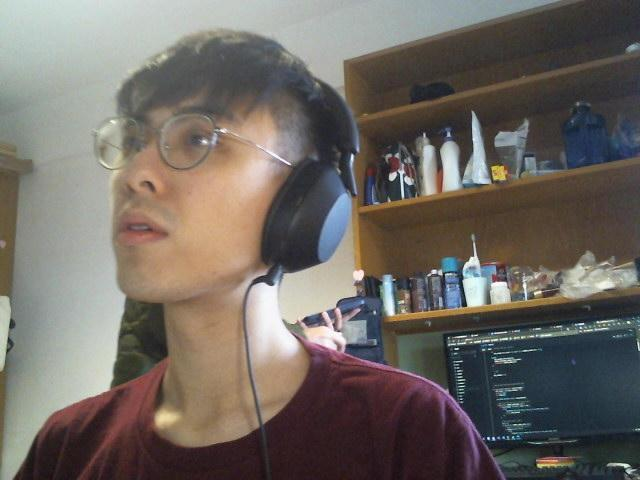

Webcam released.


In [55]:
try:
    while True:
        ret, frame = videoIn.read()
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # resize the input frame before processing
        frame_resized = cv2.resize(frame_rgb, (0, 0), fx=scale_factor, fy=scale_factor)
        gray = cv2.cvtColor(frame_resized, cv2.COLOR_RGB2GRAY)
        faces = faceCascade.detectMultiScale(gray, 1.3, 5)

        unknown_detected = False
        for (x, y, w, h) in faces:
            x, y, w, h = int(x/scale_factor), int(y/scale_factor), int(w/scale_factor), int(h/scale_factor)

            roi_gray = gray[y:y+h, x:x+w]
            if roi_gray.size == 0:
                continue

            id, confidence = recognizer.predict(roi_gray)

            if (confidence < 100):
                id = names[id]
                confidence = "  {0}%".format(round(100 - confidence))
                rectangle_color = (0, 255, 0)  # Green
            else:
                id = "unknown"
                confidence = "  {0}%".format(round(100 - confidence))
                rectangle_color = (255, 0, 0)  # Red
                unknown_detected = True

            cv2.rectangle(frame_rgb, (x, y), (x + w, y + h), rectangle_color, 2)
            cv2.putText(frame_rgb, str(id), (x+5,y-5), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
            cv2.putText(frame_rgb, str(confidence), (x+5,y+h-5), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,0), 1)
        if unknown_detected:
            gpio_control.turn_on()
        else:
            gpio_control.turn_off()    
        clear_output(wait=True)
        display(array_to_image(frame_rgb))
        # Limit the processing to the desired frame rate
        curr_time = time.time()
        elapsed_time = curr_time - prev_time
        wait_time = max(1.0/fps - elapsed_time, 0)
        time.sleep(wait_time)
        prev_time = curr_time

except KeyboardInterrupt:
    videoIn.release()
    print("Webcam released.")
